[*********************100%%**********************]  1 of 1 completed
0
1
2
3
4
5
6
7
8
9
[129.23668864 129.45787072 129.72127006 130.02729255 131.20128359
 131.6766283  132.19262731 132.74803051 133.3412879  136.05122284
 136.79987408 137.57073449 138.3601837  140.8001236  141.62290537
 142.44278502 143.25499182 144.0546869  146.33030389 147.0319213
 147.69757668 148.32312188 148.90472736 150.35360626 150.72953116
 151.04910218 151.31151739 151.51661838 151.79646118 151.78409792
 151.72365412 151.61892131 151.47427393 150.60162621 150.33977039
 150.07339653 149.80928832 149.09860283 148.9111037  148.75886397
 148.64773817 148.5831539  148.71503307 148.87989981 149.10963524
 149.40570922 149.76873438 151.25192147 151.87036534 152.5447131
 153.26981228 154.03954748 156.54196058 157.4116752  158.283161
 159.14613777 159.99011974 162.30453466 162.9710205  163.57064928
 164.09643921 164.54282346 165.37514438 165.48294016 165.5105705
 165.4638611  164.71454489 164.44526163 164.17057562 163.9

ValueError: x and y must have same first dimension, but have shapes (207,) and (140,)

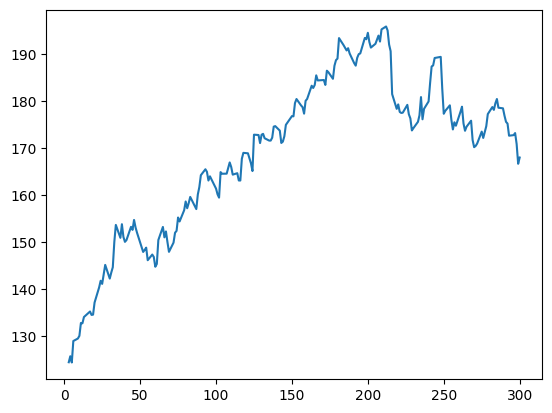

In [12]:
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates


def lppl(t, A, B, C, tc, beta, omega, phi):
    return np.exp(A + (B * (tc - t) ** beta) * (1+C * (np.cos(omega * np.log1p(tc - t) + phi)))).ravel()


def E(b1, A1, A, B, C, tc, beta, omega, phi):
    diff_1 = lppl(A1, A, B, C, tc, beta, omega, phi) - b1
    lppl_result = np.mean(diff_1**2)
    return lppl_result


def E_count(b1, A1, A, B, C, tc, beta, omega, phi):
    lppl_res = lppl(A1, A, B, C, tc, beta, omega, phi)
    print(lppl_res)
    diff_1 = lppl_res - b1
    lppl_result = np.mean(diff_1**2)
    return lppl_res, lppl_result


# 下載 APPL 歷史數據
symbol = 'AAPL'
start_date = '2023-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)
data['Day'] = data.index.dayofyear
data_reset_index = data.set_index('Day')
price_data = data_reset_index['Adj Close']

# 將每一個收盤價取對數
log_price_data = np.log1p(price_data)

A1 = price_data.index.to_numpy().reshape(-1, 1)  #放真實資料有的天數
b1 = price_data #放所有的真實資料

# 下一個程式部分
p = 10000  # 組群大小
r = 0.01  # 存活率
m = 10  # 突變數量
g = 10  # 演化代數


survive = round(p*r)  # 存活個體數目

pop = np.random.randint(0, 2, (p, 40))  # 初代，隨機的二進位基因族群,fu
fit = np.zeros((p, 1))

for generation in range(g):
    print(generation)
    # 將每個基因的適配度放入fit
    for pp in range(p):
        gene = pop[pp, :]  # 第p個基因
        # tc的數字範圍在[204,215]
        tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
        # beta的數字範圍在[0,1]
        beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
        # omega的數字沒有範圍
        omega = (np.sum(2**np.array(range(10))*gene[20:30]))
        # phi的數字範圍在[0,2pi]
        phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
        # 將 phi 映射到區間 [0, 2pi]
        phi = max(0, min(2 * np.pi, phi))

        # F1的程式碼
        n = tc
        b1 = price_data.loc[price_data.index < n]
        A1 = b1.index.to_numpy().reshape(-1, 1)
        b2 = np.zeros((n+1, 1))
        A2 = np.zeros((n+1, 3))  # 開A1二維陣列
        idx_a2 = b1.index

        for i in idx_a2:
            b2[i] = log_price_data[i]
            A2[i, 0] = 1
            A2[i, 1] = (tc-i)**beta
            A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log1p(tc - i) + phi)

        x = np.linalg.lstsq(A2, b2, rcond=None)[0]

        A = x[0]
        B = x[1]
        C = x[2] / B
        
        fit[pp] = E(b1, A1, A, B, C, tc, beta, omega, phi)
        # print(pp)

    # print("順序")
    sortf = np.argsort(fit[:, 0])  # 將裡面的數字由小到大的index獲取
    pop = pop[sortf, :]  # 使pop依照這個順序排列

    # 交配
    # print("交配")
    for i in range(survive, p):  # 從survive ~ p的基因死亡，產生孩子放回去
        # print("交配 : ", i)
        # 在前面還活者的選擇
        fid = np.random.randint(0, survive)  # 選擇父親
        mid = np.random.randint(0, survive)  # 選擇母親
        while mid == fid:  # 兩者要不同
            # print("hihi")
            mid = np.random.randint(0, survive)

        mask = np.random.randint(0, 2, (1, 40))
        son = pop[mid, :].copy()
        father = pop[fid, :]
        son[mask[0, :] == 1] = father[mask[0, :] == 1]  # 將子代mask為1的位置換成另一個父代的基因
        pop[i, :] = son

    # 突變
    # print("突變")
    for i in range(m):
        mr = np.random.randint(survive, p)
        mc = np.random.randint(0, 40)
        pop[mr, mc] = 1-pop[mr, mc]


# 計算十代之後留下的基因，計算各個基因的適配度
for i in range(p):
    gene = pop[i, :]
    tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
    beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
    omega = (np.sum(2**np.array(range(10))*gene[20:30]))
    phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
    phi = max(0, min(2 * np.pi, phi))
    fit[i] = E(b1, A1, A, B, C, tc, beta, omega, phi)

sortf = np.argsort(fit[:, 0])
pop = pop[sortf, :]

gene = pop[0, :]  # 找到fit最低就是最好的
tc = (np.sum(2**np.array(range(10)) * gene[:10]) - 511) % 12 + 204
beta = (np.sum(2**np.array(range(10))*gene[10:20])-511)/100
omega = (np.sum(2**np.array(range(10))*gene[20:30]))
phi = (np.sum(2**np.array(range(10)) * gene[30:40]) - 511) / 100
phi = max(0, min(2 * np.pi, phi))

# F1的程式碼
n = tc
b1 = price_data.loc[price_data.index < n]
A1 = b1.index.to_numpy().reshape(-1, 1)
b2 = np.zeros((n+1, 1))
A2 = np.zeros((n+1, 3))  # 開A1二維陣列
idx_a2 = b1.index

for i in idx_a2:
    b2[i] = log_price_data[i]
    A2[i, 0] = 1
    A2[i, 1] = (tc-i)**beta
    A2[i, 2] = ((tc-i)**beta) * np.cos(omega * np.log1p(tc - i) + phi)

x = np.linalg.lstsq(A2, b2, rcond=None)[0]

A = x[0]
B = x[1]
C = x[2] / B

LPPL_final, fitness_MES = E_count(b1, A1, A, B, C, tc, beta, omega, phi)

print('tc:', tc, ' beta:', beta, ' omega:', omega, ' phi:', phi)
print('A:', A, ' B:', B, ' C:', C)
print("MES : ", fitness_MES)


tc_index = int(tc)
price_data_fit = price_data.loc[price_data.index < tc_index]

time_index = price_data_fit.index
time_data = np.empty(len(time_index), dtype='datetime64[D]')

for time in range(len(time_index)):
    tt = int(time_index[time])
    date_data = pd.to_datetime('2023-01-01') + pd.DateOffset(days=tt - 1)
    time_data[time] = date_data

tc_date_1 = pd.to_datetime('2023-01-01') + pd.DateOffset(days=tc_index - 1)
tc_date = tc_date_1.strftime('%d-%b-%Y')

# Convert date values to numerical values
time_data_num = mdates.date2num(time_data)

plt.plot(time_data_num, price_data_fit, label='Actual Price Data')
plt.plot(time_data_num, LPPL_final, label='Lppl Price Data')

# Use tc_date directly without strftime, and convert it to numerical value
plt.axvline(x=mdates.date2num(tc_date_1), color='red', linestyle='--', label=f'tc = {tc_date}')


# Formatting x-axis as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('LPPL Model Fit to Price Data')
plt.xlabel('Time')
plt.ylabel('Price_data')
plt.legend()
plt.show()


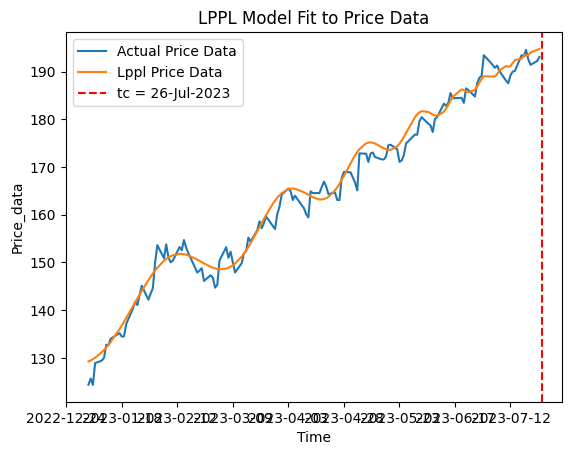

In [94]:
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
tc_index = int(tc)
price_data_fit = price_data.loc[price_data.index < tc_index]

time_index = price_data_fit.index
time_data = np.empty(len(time_index), dtype='datetime64[D]')

for time in range(len(time_index)):
    tt = int(time_index[time])
    date_data = pd.to_datetime('2023-01-01') + pd.DateOffset(days=tt - 1)
    time_data[time] = date_data

tc_date_1 = pd.to_datetime('2023-01-01') + pd.DateOffset(days=tc_index - 1)
tc_date = tc_date_1.strftime('%d-%b-%Y')

# Convert date values to numerical values
time_data_num = mdates.date2num(time_data)

plt.plot(time_data_num, price_data_fit, label='Actual Price Data')
plt.plot(time_data_num, LPPL_final, label='Lppl Price Data')

# Use tc_date directly without strftime, and convert it to numerical value
plt.axvline(x=mdates.date2num(tc_date_1), color='red', linestyle='--', label=f'tc = {tc_date}')


# Formatting x-axis as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('LPPL Model Fit to Price Data')
plt.xlabel('Time')
plt.ylabel('Price_data')
plt.legend()
plt.show()